# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.4!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.3.14
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

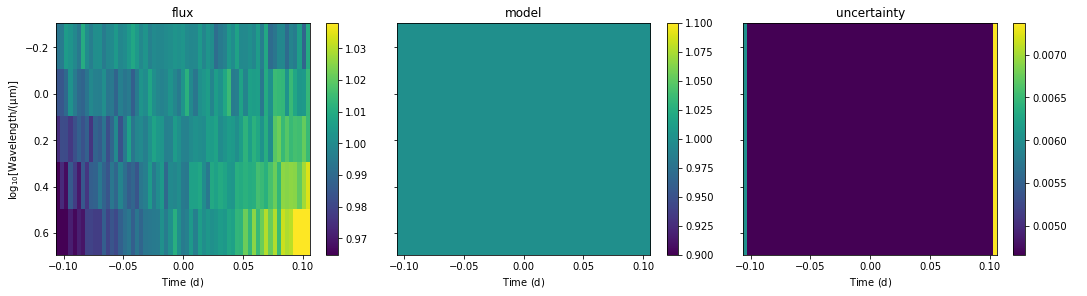

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
rb = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

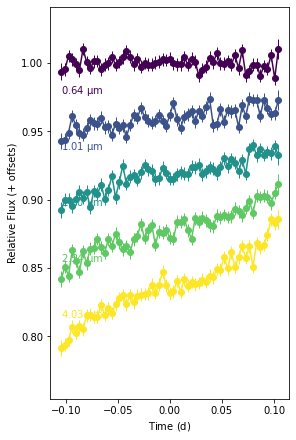

In [3]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [4]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_1 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.01,upper=50,lower=-1)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=50, lower=-1, name='polynomial_p_3') for each wavelength 🧮>



In [5]:
# setup model the same way as for the transit model!:
p.attach_data(rb)
p.setup_lightcurves()
p.setup_likelihood()

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [11]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
        wavelength_0_data ~ Normal
        wavelength_1_data ~ Normal
        wavelength_2_data ~ Normal
        wavelength_3_data ~ Normal
        wavelength_4_data ~ Normal


Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

In [7]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=1000, draws=1000, chains=4, cores=4)

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Optimization terminated successfully.
logp: -6765868.94819935 -> 1135.1080426035815
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Now we can look at our results:

In [8]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                        mean        sd    hdi_16%    hdi_84%  mcse_mean  \
polynomial_p_0[0]   0.999498  0.000416   0.999385   1.000000   0.000007   
polynomial_p_0[1]   0.999502  0.000406   0.999395   1.000000   0.000006   
polynomial_p_0[2]   0.999580  0.000361   0.999500   1.000000   0.000006   
polynomial_p_0[3]   0.999441  0.000452   0.999312   1.000000   0.000008   
polynomial_p_0[4]   0.999264  0.000552   0.999087   1.000000   0.000011   
polynomial_p_1[0]  -0.030518  0.019269  -0.046191  -0.008561   0.000381   
polynomial_p_1[1]   0.065392  0.020380   0.051142   0.091109   0.000451   
polynomial_p_1[2]   0.094862  0.025070   0.072146   0.121319   0.000454   
polynomial_p_1[3]   0.148699  0.024913   0.123634   0.172598   0.000436   
polynomial_p_1[4]   0.179923  0.024810   0.154263   0.203180   0.000350   
polynomial_p_2[0]  -0.060045  0.141613  -0.207562   0.074311   0.002266   
polynomial_p_2[1]   0.081397  0.139400  -0.058293   0.222174   0.002244   
polynomial_p_2[2]  -0.048

r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [9]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

,polynomial_p_0,polynomial_p_0_hdi_16%,polynomial_p_0_hdi_84%,polynomial_p_1,polynomial_p_1_hdi_16%,polynomial_p_1_hdi_84%,polynomial_p_2,polynomial_p_2_hdi_16%,polynomial_p_2_hdi_84%,polynomial_p_3,polynomial_p_3_hdi_16%,polynomial_p_3_hdi_84%,wavelength
w0,0.999498,0.999385,1.0,-0.030518,-0.046191,-0.008561,-0.060045,-0.207562,0.074311,2.705078,-0.882977,3.76399,0.639572482934883 micron
w1,0.999502,0.999395,1.0,0.065392,0.051142,0.091109,0.081397,-0.058293,0.222174,3.141633,-0.8405,4.349097,1.013209338074884 micron
w2,0.99958,0.9995,1.0,0.094862,0.072146,0.121319,-0.048416,-0.180496,0.086518,11.42695,8.059284,14.96976,1.604998553797903 micron
w3,0.999441,0.999312,1.0,0.148699,0.123634,0.172598,0.165584,0.021447,0.306551,13.022144,9.705742,16.712084,2.542436455025025 micron
w4,0.999264,0.999087,1.0,0.179923,0.154263,0.20318,0.350549,0.203382,0.498115,24.227525,20.890327,27.684122,4.027407446906737 micron


In [10]:
model = p.get_model()
model.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4'])

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

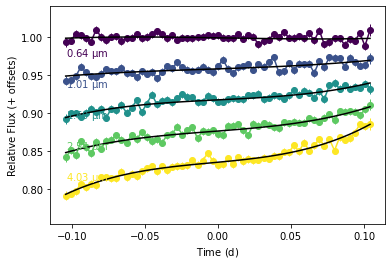

In [12]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


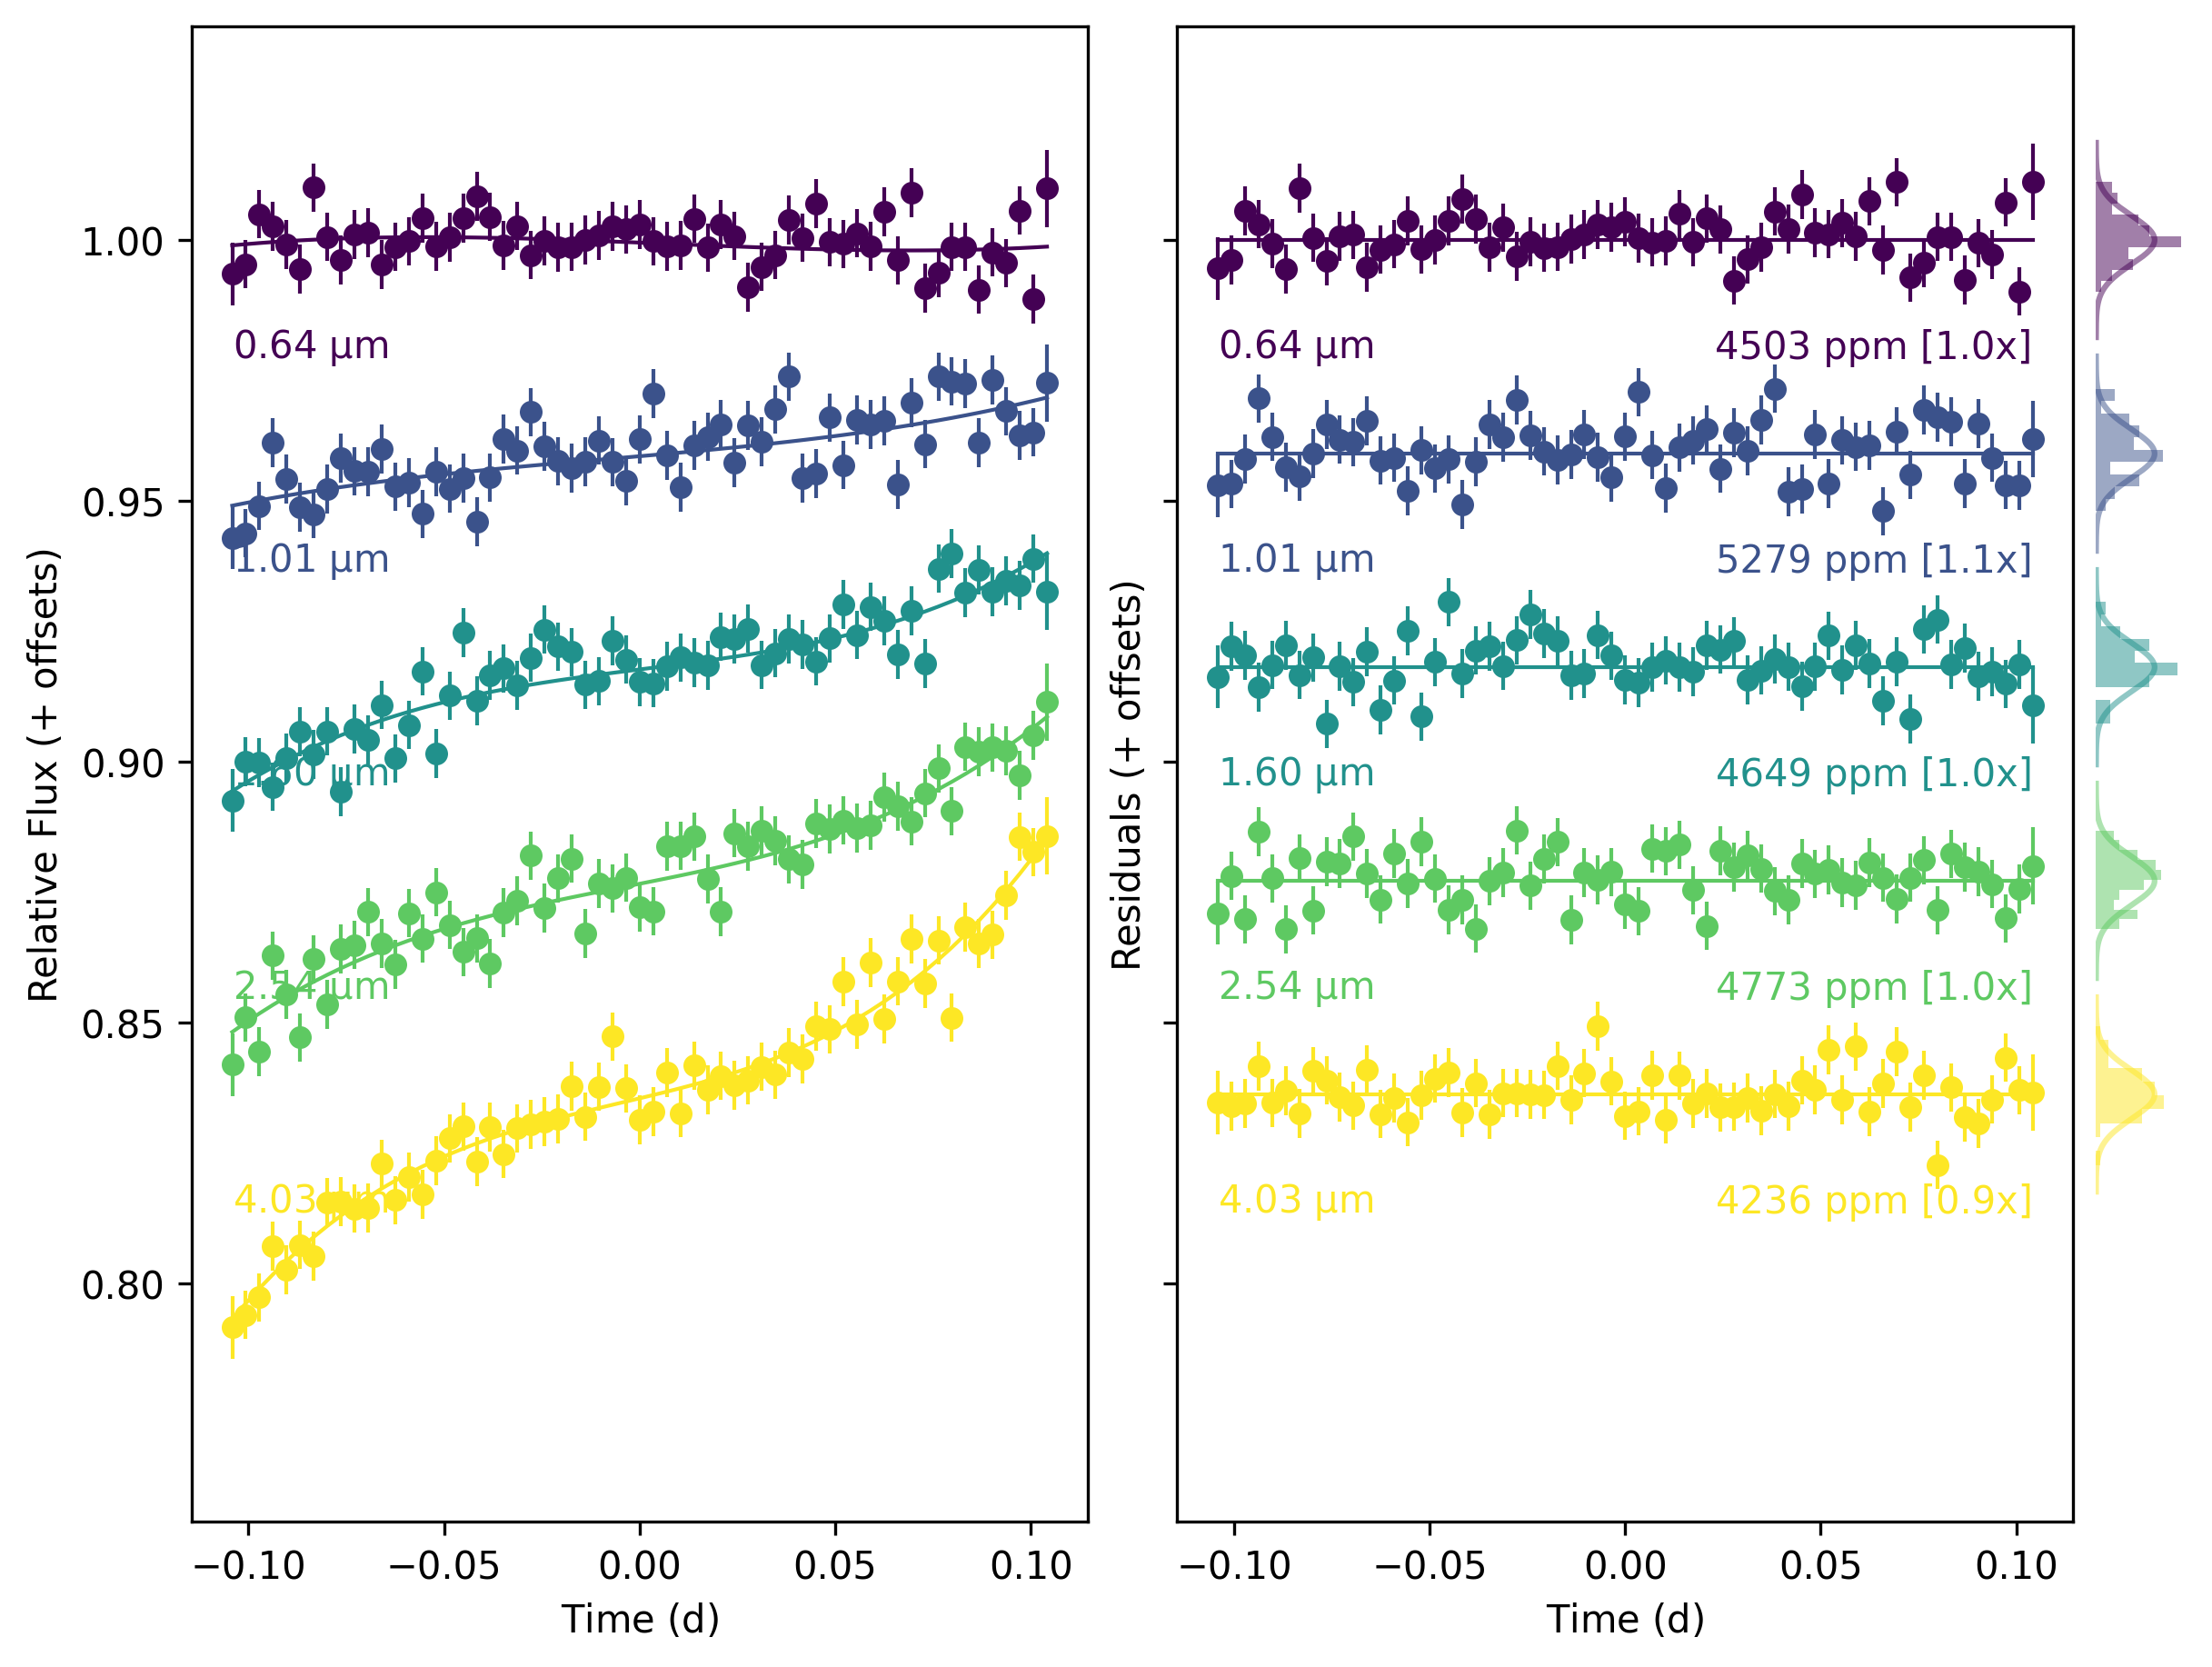

In [13]:
p.plot_with_model_and_residuals()

🌈🤖 'planet_model' doesn't exist and will be skipped.



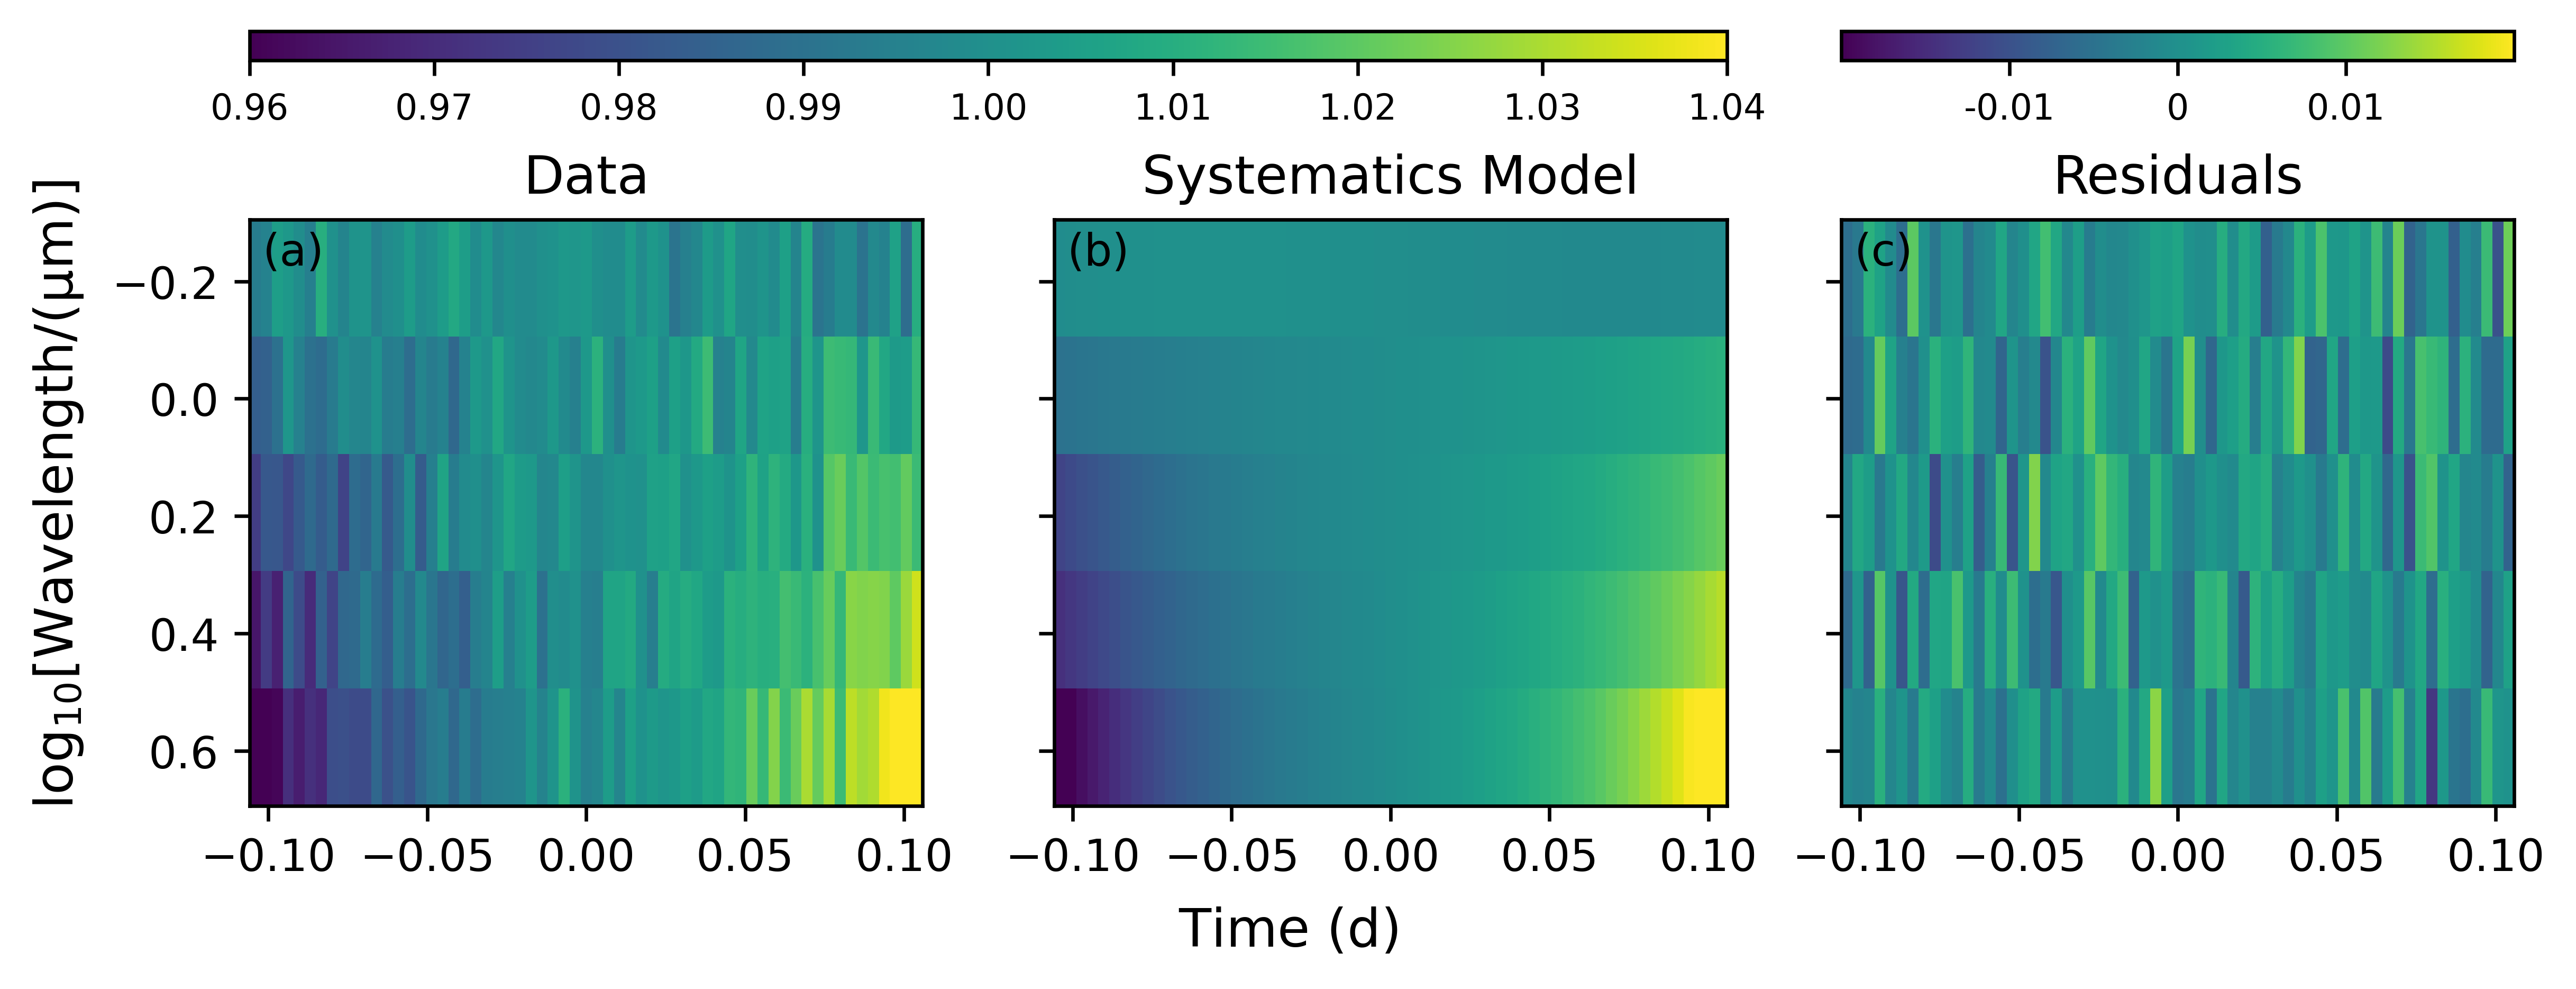

In [14]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [15]:
results = p.get_results(uncertainty=['sd','sd'])
results

,polynomial_p_0,polynomial_p_0_sd,polynomial_p_1,polynomial_p_1_sd,polynomial_p_2,polynomial_p_2_sd,polynomial_p_3,polynomial_p_3_sd,wavelength
w0,0.999498,0.000416,-0.030518,0.019269,-0.060045,0.141613,2.705078,2.520998,0.639572482934883 micron
w1,0.999502,0.000406,0.065392,0.02038,0.081397,0.1394,3.141633,2.740623,1.013209338074884 micron
w2,0.99958,0.000361,0.094862,0.02507,-0.048416,0.136161,11.42695,3.506311,1.604998553797903 micron
w3,0.999441,0.000452,0.148699,0.024913,0.165584,0.144971,13.022144,3.521462,2.542436455025025 micron
w4,0.999264,0.000552,0.179923,0.02481,0.350549,0.149967,24.227525,3.475747,4.027407446906737 micron


In [16]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

			True, 	Fitted
wavelength 0, p_0:	 1.0, 	 0.9994982 +/- 0.0004163
wavelength 0, p_1:	 0.0, 	 -0.0305179 +/- 0.0192685
wavelength 0, p_2:	 0.0, 	 -0.0600452 +/- 0.1416125
wavelength 0, p_3:	 0.0, 	 2.7050785 +/- 2.5209979
wavelength 1, p_0:	 1.0, 	 0.9995024 +/- 0.0004062
wavelength 1, p_1:	 0.05, 	 0.0653919 +/- 0.0203799
wavelength 1, p_2:	 0.0, 	 0.0813967 +/- 0.1393998
wavelength 1, p_3:	 5.0, 	 3.1416328 +/- 2.7406235
wavelength 2, p_0:	 1.0, 	 0.9995798 +/- 0.000361
wavelength 2, p_1:	 0.1, 	 0.094862 +/- 0.0250699
wavelength 2, p_2:	 0.0, 	 -0.0484157 +/- 0.1361613
wavelength 2, p_3:	 10.0, 	 11.42695 +/- 3.5063112
wavelength 3, p_0:	 1.0, 	 0.9994411 +/- 0.0004519
wavelength 3, p_1:	 0.15, 	 0.1486992 +/- 0.024913
wavelength 3, p_2:	 0.0, 	 0.1655839 +/- 0.1449707
wavelength 3, p_3:	 15.0, 	 13.0221436 +/- 3.5214615
wavelength 4, p_0:	 1.0, 	 0.9992638 +/- 0.0005519
wavelength 4, p_1:	 0.2, 	 0.1799232 +/- 0.0248103
wavelength 4, p_2:	 0.0, 	 0.350549 +/- 0.1499668
wavelength 

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

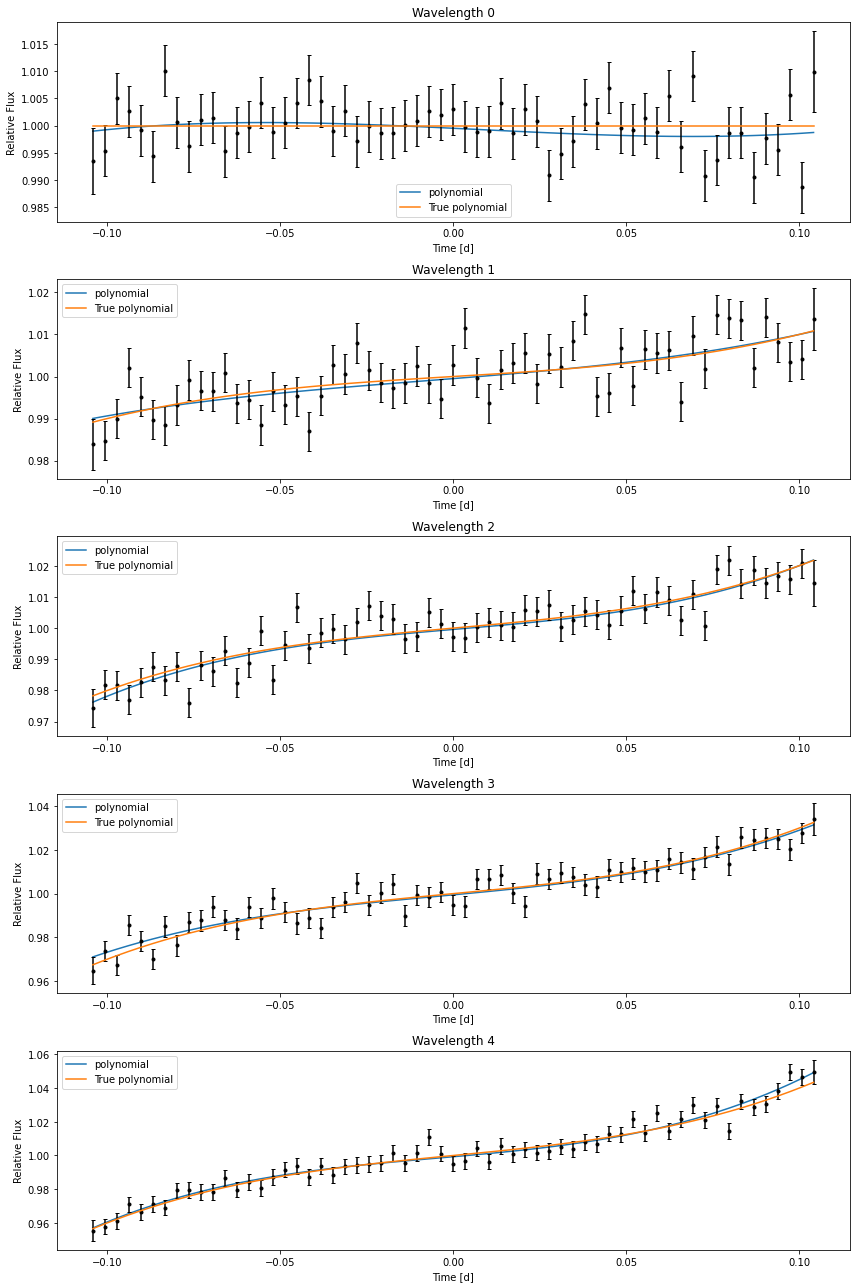

In [17]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();
for i in range(len(poly)):
    ax[i].plot(p.data.time, poly[i] + 1, label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).